In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model_bn2, lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_4_0
[INFO    ] Using numpy 1.15.1
[INFO    ] Using tensorflow 1.6.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.1.0
[INFO    ] Using sklearn 0.19.1
[INFO    ] Using matplotlib 2.2.3


In [2]:
# Training parameters

do_training = False

run2_input = False

omtf_input = False

model_name = 'model'

epochs = 300

batch_size = 4096

tile = 5

# ______________________________________________________________________________
if omtf_input:
  from nn_encode_omtf import nlayers, nvariables
  from nn_data_omtf import (muon_data_split, pileup_data_split, mix_training_inputs)
  
  model_name = 'model_omtf'
  
  epochs = 450
  
  tile = 10

### Import data

In [3]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
if not omtf_input:
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
      muon_data_split(infile_muon, reg_pt_scale=reg_pt_scale, test_size=0.306)
else:
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
      muon_data_split(infile_muon_omtf, reg_pt_scale=reg_pt_scale, test_size=0.306)
  
# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.25.npz ...
[INFO    ] Loaded the variables with shape (3076009, 179)
[INFO    ] Loaded the parameters with shape (3076009, 6)
[INFO    ] Loaded the encoded variables with shape (3076009, 36)
[INFO    ] Loaded the encoded parameters with shape (3076009,)
[INFO    ] Loaded # of training and testing events: (2134750, 941259)


In [4]:
# Import pileup data
# 'x' is the array of input variables, 'aux' is pileup info (jobid, ievt, highest_part_pt, highest_track_pt)
if not omtf_input:
  pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test, pu_x_road_train, pu_x_road_test = \
      pileup_data_split(infile_pileup, reg_pt_scale=reg_pt_scale, test_job=159)
else:
  pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test, pu_x_road_train, pu_x_road_test = \
      pileup_data_split(infile_pileup_omtf, reg_pt_scale=reg_pt_scale, test_job=159)

# Add output nodes for pileup data
if add_noise:
  labels = np.zeros((pu_x_train.shape[0],), dtype=np.float32)
  pu_y_train = [np.full((pu_x_train.shape[0],), mask_value, dtype=np.float32), labels]
  labels = np.zeros((pu_x_test.shape[0],), dtype=np.float32)
  pu_y_test = [np.full((pu_x_test.shape[0],), mask_value, dtype=np.float32), labels]

[INFO    ] Loading pileup data from ../test7/histos_tbd.25.npz ...
[INFO    ] Loaded the variables with shape (1020456, 179)
[INFO    ] Loaded the auxiliary PU info with shape (1020456, 4)
[INFO    ] Loaded the encoded variables with shape (1020456, 36)
[INFO    ] Loaded the encoded auxiliary PU info with shape (1020456, 4)
[INFO    ] Loaded # of training and testing events: (839896, 180560)


### Training

In [5]:
# Training with Batch Normalization
# 'model' is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator
# BN is applied right after the input layers

if do_training:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, 
                                                   discr_pt_cut=discr_pt_cut, tile=tile)
  else:
    raise Exception('add_noise must be set to True')
  
  model = create_model_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, 
                           l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
                           nodes1=30, nodes2=25, nodes3=20)
  logger.info('Training model with l1_reg: {0} l2_reg: {0}'.format(l1_reg, l2_reg))
  
  # Start training
  history = train_model(model, x_train_new, y_train_new,
                        model_name=model_name, epochs=epochs, batch_size=batch_size,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['regr_loss'][-1], history.history['discr_loss'][-1], 
             history.history['val_loss'][-1], history.history['val_regr_loss'][-1], history.history['val_discr_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - regr_loss: {2} - discr_loss: {3} - val_loss: {4} - val_regr_loss: {5} - val_discr_loss: {6}'.format(*metrics))

In [6]:
# Validation

if do_training:
  # Loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

if False:
  plt.figure()
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.figure()
  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Regression Results

In [7]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

In [8]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
#K.set_learning_phase(0)
loaded_model = load_my_model(name=model_name+".json", weights_name=model_name+'_weights.h5')
loaded_model.trainable = False
assert not loaded_model.updates

nentries_test = x_test.shape[0]//8

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
if isinstance(y_test_meas, list):
  y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_meas.shape, y_test_meas

[INFO    ] # of entries: 117657, mean: 0.000259156629909, std: 0.0351125970483
[INFO    ] gaus fit (a, mu, sig): [1.03589405e+04 6.54412023e-04 1.96553036e-02]


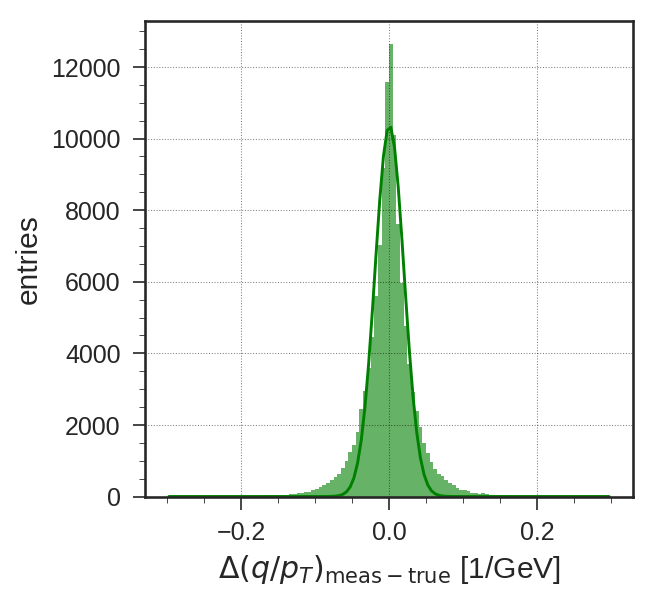

In [9]:
# Plot Delta(q/pT)
plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=120, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

[INFO    ] # of entries: 117657, mean: 0.110917784274, std: 0.217800483108
[INFO    ] gaus fit (a, mu, sig): [ 8.74908115e+03 -3.34435971e-03  1.21476812e-01]


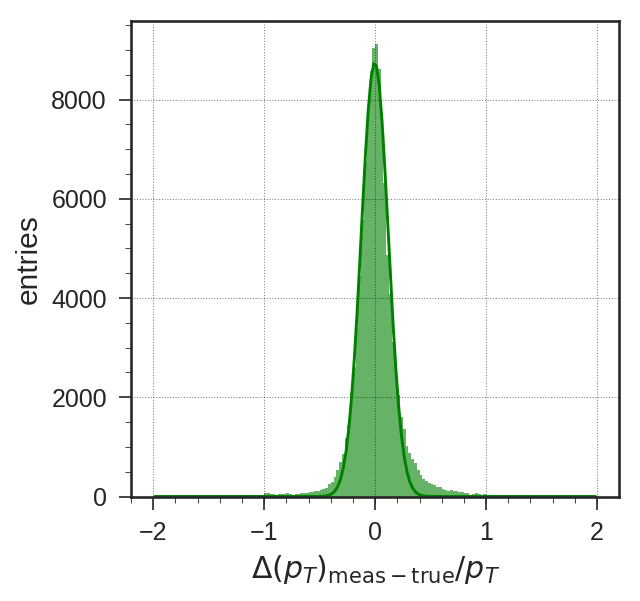

In [10]:
# Plot Delta(q/pT) / pT
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
hist, edges, _ = plt.hist(yy, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<2])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-matplotlib/2.2.3-ikaegh/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


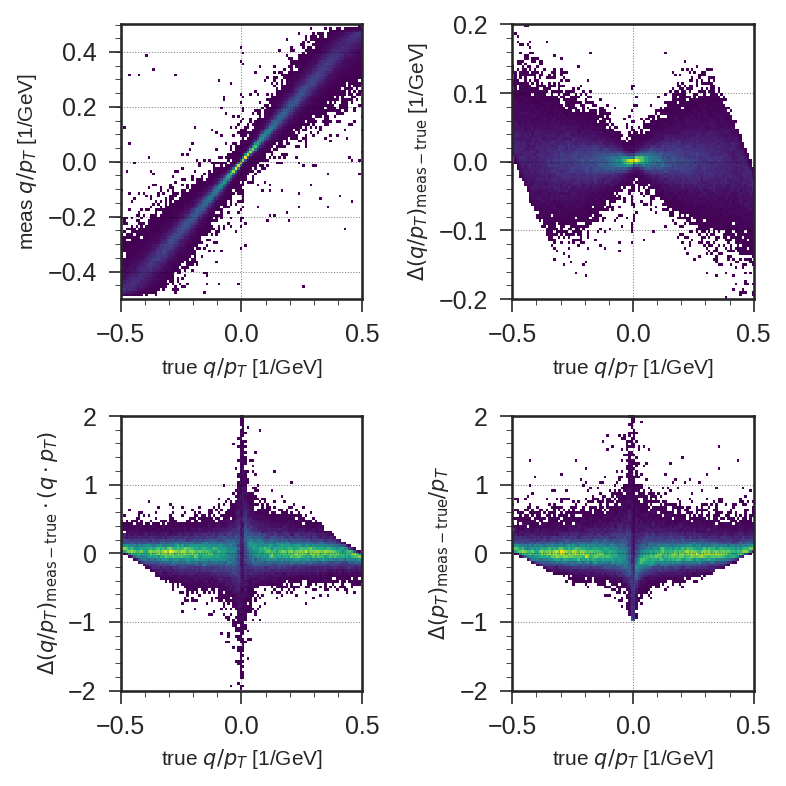

In [11]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

axs[0,0].hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_meas - y_test_true
axs[0,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
axs[1,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [12]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.3)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=160, range=(-2,2))
  #popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 22.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

[INFO    ] gaus fit (a, mu, sig): [ 7.39596440e+01 -4.32644439e-02  1.75704866e-01]


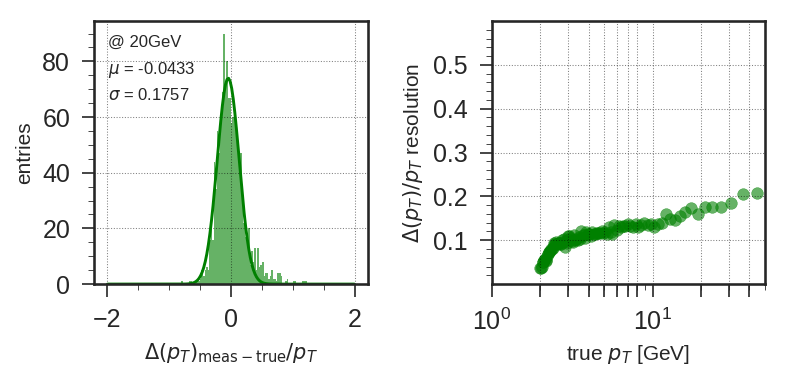

In [13]:
# Make better resolution plot
fig, axs = plt.subplots(1, 2, figsize=(5.4,5.4/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=160, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx, yyy, color='g', alpha=0.6)
axs[1].set_xlim(1,50)
axs[1].set_ylim(0,0.6+eps)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
axs[1].set_xscale('log')
axs[1].set_xticks(range(1,9) + range(10,50,10))
axs[1].set_yticks([0.1,0.2,0.3,0.4,0.5])

plt.show()

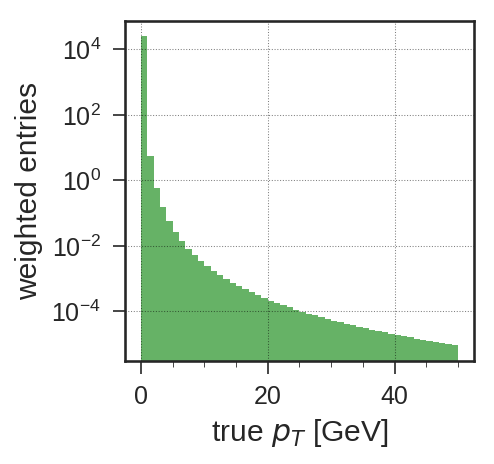

In [14]:
# Mock minbias pT spectrum
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure(figsize=(3,3))
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

In [15]:
# Predict 20 GeV rates with 90% coverage
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  if len(xx_i) < 100:  # not enough stats
    continue
  
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("20 GeV threshold {0} rate {1}".format(thresh_20GeV, np.sum(yw)))

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("22 GeV threshold {0} rate {1}".format(thresh_22GeV, np.sum(yw)))

[INFO    ] 20 GeV threshold 15.8577775955 rate 68.2320404053
[INFO    ] 22 GeV threshold 17.2863922119 rate 53.3419342041


### Classification Results

In [16]:
# Prepare y_test_true, y_test_meas (again)
y_test_true = [y_test[0][:nentries_test].copy(), y_test[1][:nentries_test].copy()]
y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)

y_test_sel = (y_test_true[1] != mask_value)  # skip low pT muons
y_test_true[0] /= reg_pt_scale
y_test_meas[0] /= reg_pt_scale
#print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
#print y_test_meas[0].shape, y_test_meas[0], y_test_meas[1].shape, y_test_meas[1]

# Prepare pu_y_test_true, pu_y_test_meas
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)  # veto PU events with high-pT tracks
pu_y_test_true = [pu_y_test[0].copy(), pu_y_test[1].copy()]
pu_y_test_meas = loaded_model.predict(pu_x_test, batch_size=4096)
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_meas[0] /= reg_pt_scale
#print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
#print pu_y_test_meas[0].shape, pu_y_test_meas[0], pu_y_test_meas[1].shape, pu_y_test_meas[1]

In [17]:
def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

def get_modes_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any((valid[0], valid[1], valid[5], valid[9], valid[11])):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any((valid[2], valid[6], valid[10])):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any((valid[3], valid[7])):  # ME3, RE3
    mode |= (1<<1)
  if np.any((valid[4], valid[8])):  # ME4, RE4
    mode |= (1<<0)

  mode_me0 = np.int32(0)
  if valid[11]: # ME0
    mode_me0 |= (1 << 1)
  if valid[0]:  # ME1/1
    mode_me0 |= (1 << 0)

  mode_mb1 = np.int32(0)
  if valid[12]: # MB1
    mode_mb1 |= (1 << 1)
  if np.any((valid[1], valid[2], valid[3], valid[5], valid[6], valid[7], valid[13], valid[14])):
    mode_mb1 |= (1 << 0)

  mode_mb2 = np.int32(0)
  if valid[13]: # MB2
    mode_mb2 |= (1 << 1)
  if np.any((valid[1], valid[2], valid[3], valid[5], valid[6], valid[7], valid[14])):
    mode_mb2 |= (1 << 0)

  mode_me13 = np.int32(0)
  if np.any((valid[1], valid[5])):  # ME1/2+3, RE1/2+3
    mode_me13 |= (1 << 1)
  if np.any((valid[2], valid[3], valid[6], valid[7])):
    mode_me13 |= (1 << 0)

  #mode_me22 = np.int32(0)
  #if np.any((valid[2], valid[6])):  # ME2/2, RE2/2+3
  #  mode_me22 |= (1 << 1)
  #if np.any((valid[3], valid[7])):
  #  mode_me22 |= (1 << 0)

  mode_omtf = np.max((mode_mb1, mode_mb2, mode_me13))
  return (mode, mode_me0, mode_omtf)

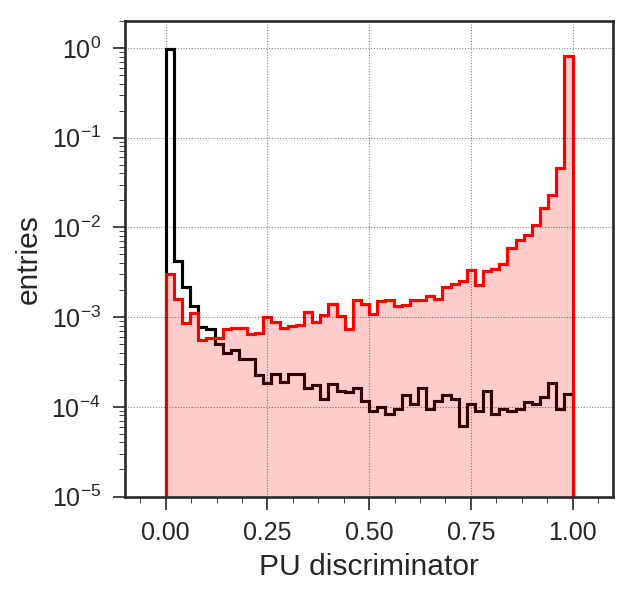

In [18]:
# Plot discriminator
plt.figure()
xx = pu_y_test_meas[1][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[1][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))
plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black', lw=1.5)
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='stepfilled', color='red', alpha=0.2)
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red', lw=1.5)
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
plt.xlim(-0.1, 1.1)
plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

# Calculate separation score?

In [19]:
# Plot ROC
from sklearn.metrics import roc_curve, roc_auc_score

xx = np.concatenate((y_test_true[1][y_test_sel], pu_y_test_true[1][pu_y_test_sel]))
yy = np.concatenate((y_test_meas[1][y_test_sel], pu_y_test_meas[1][pu_y_test_sel]))
zz = np.concatenate((y_test_meas[0][y_test_sel], pu_y_test_meas[0][pu_y_test_sel]))
tt = np.concatenate((x_mask_test[:nentries_test][y_test_sel], pu_x_mask_test[pu_y_test_sel]))

def roc_singlemu(x_mask):
  (mode, mode_me0, mode_omtf) = get_modes_from_x_mask(x_mask)
  if omtf_input:
    mode_ok = (mode in (11,13,14,15)) or (mode_omtf == 3)
  else:
    mode_ok = (mode in (11,13,14,15)) or (mode_me0 == 3)
  return mode_ok

tt = np.apply_along_axis(roc_singlemu, 1, tt)  # require SingleMu quality
xx = xx[:, np.newaxis]
xx = xx[tt]
yy = yy[tt]
zz = zz[tt]

[INFO    ] auc: 0.996773588725
[INFO    ] thr: [0.9586, 0.9368, 0.8963, 0.8323, 0.8024, 0.7628, 0.7142, 0.6105, 0.0542]
[INFO    ] tpr: [0.9015, 0.9251, 0.9508, 0.9703, 0.9751, 0.9801, 0.9852, 0.9901, 0.9990]
[INFO    ] fpr: [0.0065, 0.0121, 0.0181, 0.0268, 0.0296, 0.0355, 0.0387, 0.0455, 0.1085]
[INFO    ] auc: 0.998931791334
[INFO    ] thr: [0.9942, 0.9906, 0.9818, 0.9627, 0.9567, 0.9340, 0.9168, 0.8619, 0.0901]
[INFO    ] tpr: [0.9025, 0.9297, 0.9542, 0.9740, 0.9770, 0.9838, 0.9863, 0.9902, 0.9991]
[INFO    ] fpr: [0.0021, 0.0024, 0.0036, 0.0045, 0.0052, 0.0073, 0.0085, 0.0115, 0.0446]


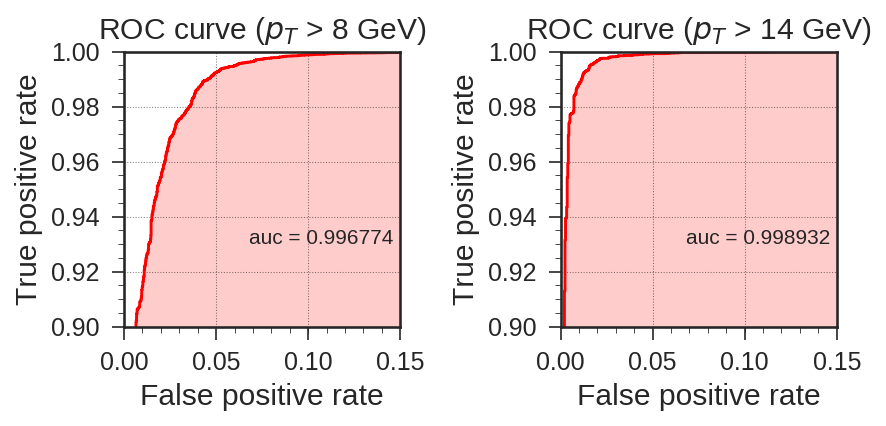

In [20]:
# Plot ROC
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]

# pT > 8 GeV, corresponding to 10 GeV trigger threshold
zzz = np.abs(1.0/zz) > discr_pt_cut
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_meas)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[0].plot(fpr, tpr, color='r')
axs[0].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[0].set_title(r'ROC curve ($p_{T}$ > 8 GeV)')
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[0].set_xlim(0.0,0.15)
axs[0].set_ylim(0.9,1.0)

# pT > 14 GeV, corresponding to 20 GeV trigger threshold
zzz = np.abs(1.0/zz) > discr_pt_cut_high
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_meas)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{T}$ > 14 GeV)')
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.15)
axs[1].set_ylim(0.9,1.0)

plt.show()

### Efficiency & Rates 

In [21]:
# Build track producer

from six.moves import range, zip, map, filter

#pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

pt_bins = (-0.49376795, -0.38895044, -0.288812, -0.19121648, -0.0810074, 0.0810074, 0.19121648, 0.288812, 0.38895044, 0.49376795)

#pt_bins = (-0.49349323, -0.38373062, -0.28128058, -0.18467896, -0.07760702, 0.07760702, 0.18467896, 0.28128058, 0.38373062, 0.49349323)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - np.abs(ipt - best_ipt)

theta_to_eta_lut = [
  2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
  2.309, 2.284, 2.259, 2.236, 2.212, 2.190, 2.167, 2.145, 2.124, 2.103,
  2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.950, 1.932, 1.915,
  1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.800, 1.785, 1.770, 1.755,
  1.740, 1.726, 1.711, 1.697, 1.683, 1.670, 1.656, 1.642, 1.629, 1.616,
  1.603, 1.590, 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
  1.482, 1.470, 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
  1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
  1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
  1.180, 1.171, 1.162, 1.154, 1.145, 1.136, 1.128, 1.119, 1.111, 1.103,
  1.094, 1.086, 1.078, 1.070, 1.062, 1.054, 1.046, 1.038, 1.030, 1.022,
  1.014, 1.007, 0.999, 0.991, 0.984, 0.976, 0.969, 0.961, 0.954, 0.946,
  0.939, 0.932, 0.924, 0.917, 0.910, 0.903, 0.896, 0.888, 0.881, 0.874,
  0.867, 0.860, 0.853, 0.847, 0.840, 0.833, 0.826, 0.819, 0.813, 0.806,
  0.799, 0.793, 0.786, 0.779, 0.773, 0.766, 0.760, 0.753, 0.747, 0.741
]
theta_to_eta_lut = np.asarray(theta_to_eta_lut)

def theta_to_eta_f(theta):
  eta = theta_to_eta_lut[theta.astype(np.int32)]
  return eta

In [22]:
class TrackProducer(object):
  def __init__(self, omtf_input=False, run2_input=False):
    self.omtf_input = omtf_input
    self.run2_input = run2_input

    self.discr_pt_cut = 8.
    self.discr_pt_cut_high = 14.

    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.8117,  1.5459,  1.5950,  1.8402,  2.2030,  2.6381,  3.1232,  3.6518,
                  4.2296,  4.8608,  5.5156,  6.1841,  6.8641,  7.5456,  8.2256,  8.8992,
                  9.5510, 10.1803, 10.8062, 11.4385, 12.0905, 12.7651, 13.4559, 14.1654,
                 14.8802, 15.6057, 16.3493, 17.1033, 17.8604, 18.6140, 19.3572, 20.0806,
                 20.7999, 21.5515, 22.3629, 23.1690, 23.8621, 24.4932, 25.1597, 25.8896,
                 26.6617, 27.4547, 28.2172, 28.9402, 29.6450, 30.3504, 31.0774, 31.8438,
                 32.6296, 33.4444, 34.3235, 35.2550, 36.1904, 37.1498, 38.1237, 39.0754,
                 39.9981, 40.8433, 41.6487, 42.4566, 43.3854, 44.4498, 45.6840, 46.8737,
                 47.8861, 48.8104, 49.7933, 50.7312, 51.5319, 52.3184, 53.1023, 53.8850,
                 54.6672, 55.4490, 56.2307, 57.0122, 57.7937, 58.5751, 59.3564, 60.1378,
                 60.9191, 61.7004, 62.4817, 63.2630, 64.0442, 64.8255, 65.6067, 66.3880,
                 67.1692, 67.9505, 68.7317, 69.5129, 70.2942, 71.0754, 71.8566, 72.6379,
                 73.4191, 74.2003, 74.9816, 75.7628, 76.5440, 77.3252, 78.1065, 78.8877,
                 79.6689, 80.4501, 81.2314, 82.0126, 82.7938, 83.5750, 84.3563, 85.1375,
                 85.9187, 86.6999, 87.4812, 88.2624, 89.0436, 89.8248, 90.6061, 91.3873]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)

  def get_trigger_pt(self, x, y_meas):
    xml_pt = np.abs(1.0/y_meas)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-5)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return binx.astype(np.int32)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if binx == self.s_nbins-1:  # check boundary
      binx -= 1

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, ndof, modes, strg, zone, theta_median, y_meas, y_discr):
    ipt1 = strg
    ipt2 = find_pt_bin(y_meas)
    quality1 = find_emtf_road_quality(ipt1)
    quality2 = find_emtf_road_quality(ipt2)

    (mode, mode_me0, mode_omtf) = modes
    if self.omtf_input:
      mode_ok = (mode in (11,13,14,15)) or (mode_omtf == 3)
    else:
      mode_ok = (mode in (11,13,14,15)) or (mode_me0 == 3)

    strg_ok = quality2 <= (quality1+1)

    trigger = (y_discr < 0.)  # False

    if mode_ok:
      if self.omtf_input:
        if np.abs(1.0/y_meas) > self.discr_pt_cut_high:  # >14 GeV
          trigger = (y_discr > 0.6063) # 98.0% coverage
        elif np.abs(1.0/y_meas) > self.discr_pt_cut:  # 8-14 GeV
          trigger = (y_discr > 0.2867) # 98.0% coverage
        else:
          trigger = (y_discr >= 0.) and strg_ok
      else:
        if np.abs(1.0/y_meas) > self.discr_pt_cut_high:  # >14 GeV
          trigger = (y_discr > 0.9281) # 98.0% coverage
        elif np.abs(1.0/y_meas) > self.discr_pt_cut:  # 8-14 GeV
          trigger = (y_discr > 0.7628) # 98.0% coverage
        else:
          trigger = (y_discr >= 0.) and strg_ok
    return trigger

  def run(self, slim_roads, variables, predictions, x_mask_vars, x_road_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(x_mask_vars))
    assert(len(slim_roads) == len(x_road_vars))

    tracks = []

    for myroad, x, y, x_mask, x_road in zip(slim_roads, variables, predictions, x_mask_vars, x_road_vars):
      assert(len(x.shape) == 1)
      assert(y.shape == (1,2))
      assert(x_mask.shape == (nlayers,))
      assert(x_road.shape == (3,))

      y_meas = np.asscalar(y[0,0])
      y_discr = np.asscalar(y[0,1])
      ndof = get_ndof_from_x_mask(x_mask)
      modes = get_modes_from_x_mask(x_mask)
      strg, zone, theta_median = x_road

      passed = self.pass_trigger(ndof, modes, strg, zone, theta_median, y_meas, y_discr)
      xml_pt = np.abs(1.0/y_meas)
      pt = self.get_trigger_pt(x, y_meas)

      if passed:
        trk_q = np.sign(y_meas)
        trk_emtf_phi = myroad.id[4]
        trk_emtf_theta = theta_median
        trk = Track(myroad.id, myroad.hits, modes[0], zone, xml_pt, pt, trk_q, trk_emtf_phi, trk_emtf_theta, ndof, y_discr)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer(omtf_input=omtf_input, run2_input=run2_input)

In [23]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, x_road, y_meas, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, x_road_test, y_test_meas[0], y_test_meas[1], y_test_true[0])):
  ndof = get_ndof_from_x_mask(x_mask)
  modes = get_modes_from_x_mask(x_mask)
  strg, zone, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, modes, strg, zone, theta_median, y_meas, y_discr)
  xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20:
    print ievt, ndof, float(y_discr), float(pt_true), float(xml_pt), float(pt), passed
  
eff_data = np.asarray(eff_data)

0 6 5.28435739398e-05 2.30123738096 2.33743858337 2.49663905525 [ True]
1 4 2.39173059526e-05 2.06894707895 2.15112447739 2.33450852022 [ True]
2 8 0.837382137775 7.47499204704 8.06976127625 9.63880154228 [ True]
3 6 3.77274005814e-07 2.40684616044 2.5048494339 2.64280492077 [ True]
4 6 1.43053121064e-05 2.39490055624 2.43938589096 2.58535360231 [ True]
5 7 0.000834162114188 2.04488624134 2.40035057068 2.5513850666 [ True]
6 6 0.00791765190661 5.61520493711 5.76294374466 6.54170349274 [ True]
7 7 0.000131381108076 2.64305440334 2.87173318863 2.99875553961 [ True]
8 4 9.72011912381e-05 3.14157572047 3.0073261261 3.13094518051 [ True]
9 8 0.99999332428 89.1602871286 52.4177131653 80.3215350494 [ True]
10 7 0.420673817396 8.51886571623 7.35665178299 8.70608128204 [ True]
11 5 5.71843474972e-06 3.06168298421 2.66736602783 2.8004785202 [ True]
12 8 0.912379622459 7.93039662226 8.76394367218 10.5107046888 [ True]
13 7 0.990007638931 8.24474644979 9.29000473022 11.1729399818 [ True]
14 8 0.00

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


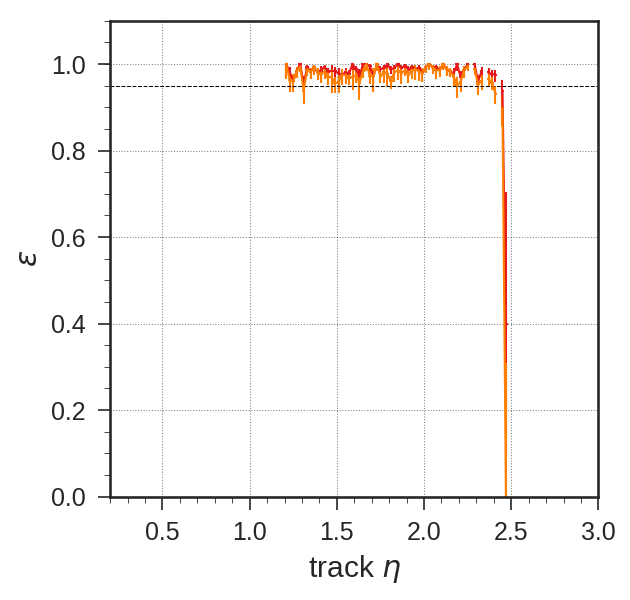

In [24]:
# Efficiency vs eta
plt.figure()

nbinsx = 90
xlow = 0.7
xup = 2.5

eff_data_theta = eff_data[:, 5]  # index 5 is theta_median
eff_data_eta = np.apply_along_axis(theta_to_eta_f, 0, eff_data_theta)

pt_thresh = 20
gen_pt_thresh = 30
gen_passed = eff_data[:, 1] > gen_pt_thresh  # index 1 is pt_true
denom_hist, edges = np.histogram(eff_data_eta[gen_passed], bins=nbinsx, range=(xlow,xup))  

color = my_palette[1]
passed = gen_passed & (eff_data[:, 3] > pt_thresh)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

color = my_palette[3]
passed = gen_passed & (eff_data[:, 3] > pt_thresh) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data_eta[passed], bins=nbinsx, range=(xlow,xup))
eff_hist = np.true_divide(num_hist, denom_hist)

yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)
  
plt.plot([xlow-0.5,xup+0.5], [0.95,0.95], ls='dashed', lw=0.5, color='black')
plt.xlim(xlow-0.5,xup+0.5)
plt.ylim(0,1.1)
plt.xlabel(r'track $\eta$')
plt.ylabel(r'$\epsilon$')
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.9.0-ikaegh/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


10.0 [           nan            nan            nan            nan
 4.75406839e-04 8.36202656e-04 2.85626061e-03 1.36589883e-02
 5.45865633e-02 2.07931639e-01 6.02022059e-01 9.07230877e-01
 9.67474490e-01 9.76952625e-01 9.81345393e-01 9.72793630e-01
 9.79218620e-01 9.86341463e-01 9.79069767e-01 9.84243697e-01
 9.95155039e-01 9.89247312e-01 9.81399469e-01 9.86474301e-01
 9.90662932e-01 9.79768786e-01]
20.0 [           nan            nan            nan            nan
 1.82848784e-04 9.83767831e-05 1.54392466e-04 5.78770691e-04
 6.45994832e-04 4.16301490e-03 9.49754902e-03 4.62683097e-02
 1.43494898e-01 3.69611609e-01 6.52345958e-01 8.08228268e-01
 9.06899418e-01 9.53170732e-01 9.57364341e-01 9.71638655e-01
 9.91279070e-01 9.85663082e-01 9.76970771e-01 9.81965735e-01
 9.89729225e-01 9.71098266e-01]
30.0 [           nan            nan            nan            nan
 1.09709270e-04 4.91883915e-05 7.71962328e-05 4.63016553e-04
 3.22997416e-04 6.57318142e-04 2.14460784e-03 6.97512206e-03
 1.498

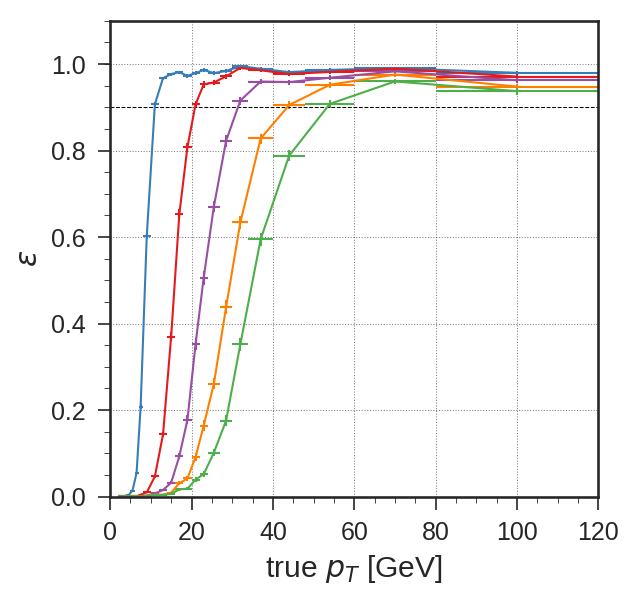

In [25]:
# Efficiency vs pT
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

pt_list = (10., 20., 30., 40., 50., 60.)

plt.figure()

if omtf_input:
  gen_passed = (0.8 <= eff_data_eta) & (eff_data_eta <= 1.24)
else:
  gen_passed = (1.24 <= eff_data_eta) & (eff_data_eta <= 2.4)

denom_hist, edges = np.histogram(eff_data[:, 1][gen_passed], bins=eff_pt_bins)  # index 1 is pt_true

for pt, color in zip(pt_list, my_palette):
  passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is pt_true
  eff_hist = np.true_divide(num_hist, denom_hist)
  
  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  print pt, ydata
  
  plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [26]:
# Find out pT scale factor

nbinsx = 120
xedges = np.linspace(0, 60, num=nbinsx+1)  # 0.5GeV step size

xxx = np.zeros((5,nbinsx), dtype=np.float32)

for j in xrange(5):  # j = zone0-1, zone2-4, zone5, zone6, all zones
  if j == 0:
    eff_data_tmp = np.logical_or(eff_data[:,0]==0, eff_data[:,0]==1)
  elif j == 1:
    eff_data_tmp = np.logical_or(eff_data[:,0]==2, eff_data[:,0]==3, eff_data[:,0]==4)
  elif j == 2:
    eff_data_tmp = (eff_data[:,0]==5)
  elif j == 3:
    eff_data_tmp = (eff_data[:,0]==6)
  elif j == 4:
    eff_data_tmp = (eff_data[:,0]>=0)
  
  xx = eff_data[:,1][eff_data_tmp]  # pt_true
  yy = eff_data[:,2][eff_data_tmp]  # xml_pt
  zz = eff_data[:,4][eff_data_tmp]  # discr_passed
  
  ind = np.digitize(xx, xedges[1:])
  
  for i in xrange(nbinsx):  # i = pT in 0.5GeV step
    if xedges[i] <= 4:  # ignore below 4 GeV
      xxx[j,i] = xedges[i]
      continue
    
    if xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 36:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size
    xx_i = xx[(i <= ind) & (ind <= i+step)]
    yy_i = yy[(i <= ind) & (ind <= i+step)]
    zz_i = zz[(i <= ind) & (ind <= i+step)]
    coverage = 90  
    coverage += 1.0 # inefficiency due to fiducial cuts
    #coverage += 1.5 # inefficiency due to fiducial cuts
    #pct = np.percentile(yy_i, 100-coverage, overwrite_input=True)
    
    yz_i = np.where(zz_i==0, 0, yy_i)  # muons who passed
    if len(yz_i) < 100:  # not enough stats
      continue
    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    
    xxx[j,i] = pct
    
    # Debug
    if j == 4 and 14 <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)

#print np.array2string(xxx, separator=', ', precision=4, floatmode='fixed')

14.0 1.5535292131
14.5 1.69859053126
15.0 1.41955835962
15.5 1.5708970649
16.0 1.66374781086
16.5 1.63710777626
17.0 1.8536121673
17.5 1.93069306931
18.0 1.93312434692
18.5 2.11463550362
19.0 2.0202020202
19.5 1.74346201743
20.0 1.7823042648
20.5 1.44736842105
21.0 1.10420979986
21.5 1.30057803468
22.0 1.13808801214
22.5 0.963855421687
23.0 1.63652024117
23.5 1.75284837862
24.0 1.85840707965
24.5 2.14285714286
25.0 2.30414746544
25.5 2.02985074627
26.0 1.91476219889
26.5 1.70491803279
27.0 1.30494505495
27.5 1.2729844413
28.0 1.16703136397
28.5 1.05105105105
29.0 0.799360511591
29.5 0.729927007299
30.0 0.816326530612


[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

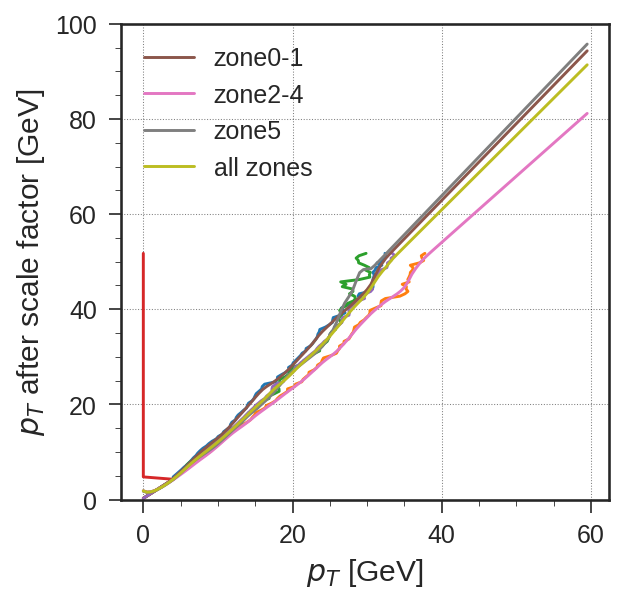

In [27]:
plt.figure()

xdata = (xedges[1:] + xedges[:-1])/2
plt.plot(xxx[0,:-16], xdata[:-16])
plt.plot(xxx[1,:-16], xdata[:-16])
plt.plot(xxx[2,:-16], xdata[:-16])
plt.plot(xxx[3,:-16], xdata[:-16])
plt.plot(xxx[4,:-16], xdata[:-16])
plt.xlabel(r'$p_{T}$ [GeV]')
plt.ylabel(r'$p_{T}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf4 = Rbf(xxx[4,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')

xdata = xedges[:-1]
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)
ydata4 = rbf4(xdata)

if not omtf_input:
  line0, = plt.plot(xdata, ydata0)
  line1, = plt.plot(xdata, ydata1)
  line2, = plt.plot(xdata, ydata2)
  #line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line0, line1, line2, line4), ('zone0-1', 'zone2-4', 'zone5', 'all zones'), loc='upper left')
else:
  #line0, = plt.plot(xdata, ydata0)
  #line1, = plt.plot(xdata, ydata1)
  #line2, = plt.plot(xdata, ydata2)
  line3, = plt.plot(xdata, ydata3)
  line4, = plt.plot(xdata, ydata4)
  plt.legend((line3, line4), ('zone6', 'all zones'), loc='upper left')

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata4, separator=', ', precision=4, floatmode='fixed')

def monotonically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
assert(monotonically_increasing(ydata4[6:]))

plt.ylim(0,100)
plt.show()

In [28]:
# Rates
rates_jobid_offset = 159 - 30
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for ievt, (x, x_mask, x_road, y_meas, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_x_road_test, pu_y_test_meas[0], pu_y_test_meas[1], pu_aux_test)):
  ndof = get_ndof_from_x_mask(x_mask)
  modes = get_modes_from_x_mask(x_mask)
  strg, zone, theta_median = x_road
  
  passed = mytrigger.pass_trigger(ndof, modes, strg, zone, theta_median, y_meas, y_discr)
  #xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  
  trk_eta = theta_to_eta_f(theta_median)
  if omtf_input:
    trk_eta_ok = (0.8 <= trk_eta <= 1.24)
  else:
    trk_eta_ok = (1.24 <= trk_eta <= 2.4)
  
  if jobid < (rates_njobs-1):
    if passed and trk_eta_ok:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and trk_eta_ok:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_jobs = (31,50,56,60,)
  if jobid in test_jobs and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt), ndof, pt, y_discr
    if pt > 100.:  # why?
      with np_printoptions(precision=3, suppress=True):
        if omtf_input:
          nlayers1 = 9
        else:
          nlayers1 = 12
        for lay in xrange(nlayers1):
          tmp = np.arange(2) * nlayers1 + lay
          print "....", lay, x[tmp]

  31 2826 19.5646 27.5000 7 [24.18264306] [0.9972072]
  31 2937 11.6057 18.0000 7 [40.15647183] [0.9842093]
  50 6191 19.5523 14.5000 6 [30.95954094] [0.9476913]
  50 6212  1.3540 12.5000 8 [50.42498286] [0.9985857]
  56 5213 12.2996 21.5000 8 [21.98428649] [0.9859039]
  56 6219  3.7920 10.0000 6 [143.06071903] [0.97842777]
.... 0 [0. 0.]
.... 1 [0.094 7.75 ]
.... 2 [-0.125  7.5  ]
.... 3 [-0.188  7.375]
.... 4 [-0.844  7.375]
.... 5 [0. 0.]
.... 6 [-0.625  8.   ]
.... 7 [-0.625  7.5  ]
.... 8 [0. 0.]
.... 9 [0. 0.]
.... 10 [0. 0.]
.... 11 [0. 0.]
  60 2642 14.2474 26.5000 8 [20.70212894] [0.9985092]


[INFO    ] nevents: 258400/498400


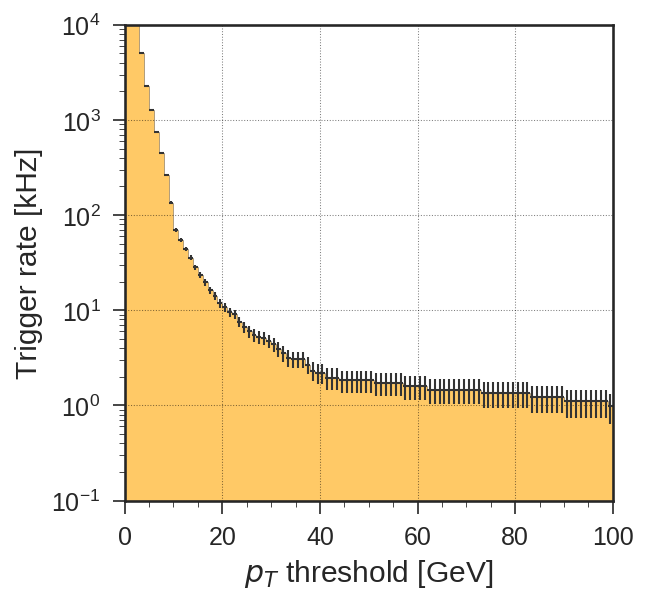

[INFO    ] Rates in kHz at 18/19/20/21/22 GeV: 14.1762273386, 11.8542590216, 10.7543792799, 9.53229070455, 9.04345528036


[1.3659e+04, 1.3659e+04, 1.3659e+04, 5.1041e+03, 2.2623e+03, 1.2610e+03,
 7.3875e+02, 4.5144e+02, 2.6654e+02, 1.3529e+02, 6.9903e+01, 5.5116e+01,
 4.4117e+01, 3.5563e+01, 2.8352e+01, 2.3464e+01, 1.9676e+01, 1.6254e+01,
 1.4176e+01, 1.1854e+01, 1.0754e+01, 9.5323e+00, 9.0435e+00, 7.5769e+00,
 6.5993e+00, 5.9882e+00, 5.4994e+00, 5.2550e+00, 5.1328e+00, 4.7661e+00,
 4.3995e+00, 3.9107e+00, 3.5441e+00, 3.1774e+00, 3.0552e+00, 3.0552e+00,
 3.0552e+00, 2.6886e+00, 2.3220e+00, 2.1998e+00, 2.1998e+00, 1.9553e+00,
 1.9553e+00, 1.9553e+00, 1.8331e+00, 1.8331e+00, 1.8331e+00, 1.8331e+00,
 1.8331e+00, 1.8331e+00, 1.8331e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00,
 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.5887e+00, 1.5887e+00, 1.5887e+00,
 1.5887e+00, 1.5887e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00, 1.4665e+00,
 1.4665e+00, 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.3443e+00,
 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.3443e+00, 1.

In [29]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

logger.info("Rates in kHz at 18/19/20/21/22 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[19], hist[20], hist[21], hist[22]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

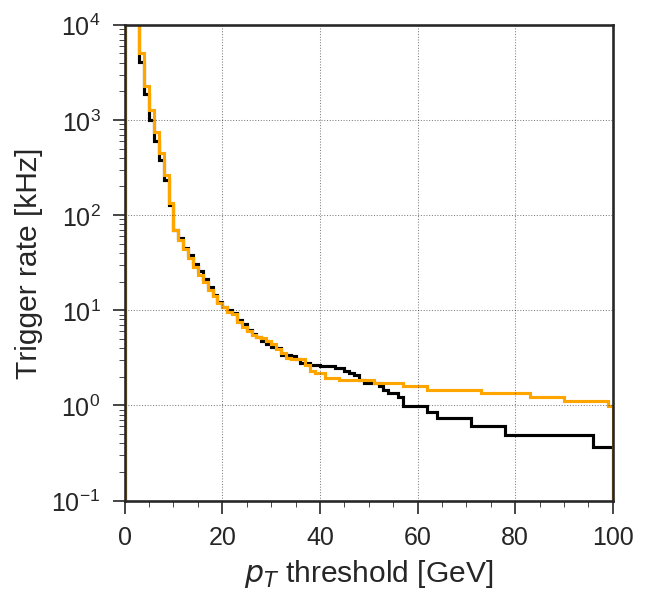

In [30]:
# Old rates
old_hist = [1.0308e+04, 1.0308e+04, 1.0308e+04, 4.0897e+03, 1.8846e+03, 9.9760e+02,
 5.9589e+02, 3.7664e+02, 2.3440e+02, 1.2795e+02, 7.0148e+01, 5.7560e+01,
 4.5217e+01, 3.8007e+01, 3.0797e+01, 2.5542e+01, 2.1509e+01, 1.7354e+01,
 1.4421e+01, 1.2343e+01, 1.0877e+01, 1.0143e+01, 9.2878e+00, 7.8213e+00,
 7.0881e+00, 6.2326e+00, 5.6216e+00, 5.2550e+00, 4.7661e+00, 4.3995e+00,
 4.1551e+00, 4.0329e+00, 3.4218e+00, 3.4218e+00, 3.2996e+00, 3.0552e+00,
 2.8108e+00, 2.8108e+00, 2.6886e+00, 2.6886e+00, 2.5664e+00, 2.5664e+00,
 2.5664e+00, 2.4442e+00, 2.4442e+00, 2.3220e+00, 2.1998e+00, 2.0775e+00,
 1.8331e+00, 1.7109e+00, 1.7109e+00, 1.7109e+00, 1.5887e+00, 1.4665e+00,
 1.3443e+00, 1.3443e+00, 1.2221e+00, 9.7767e-01, 9.7767e-01, 9.7767e-01,
 9.7767e-01, 9.7767e-01, 8.5546e-01, 8.5546e-01, 7.3325e-01, 7.3325e-01,
 7.3325e-01, 7.3325e-01, 7.3325e-01, 7.3325e-01, 7.3325e-01, 6.1104e-01,
 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01, 6.1104e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01, 4.8883e-01,
 3.6663e-01, 3.6663e-01, 3.6663e-01, 3.6663e-01]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
centers = (edges[1:] + edges[:-1])/2
plt.hist(centers, weights=old_hist, bins=edges, histtype='step', color='k', lw=1.5)
plt.hist(centers, weights=hist, bins=edges, histtype='step', color='orange', lw=1.5)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

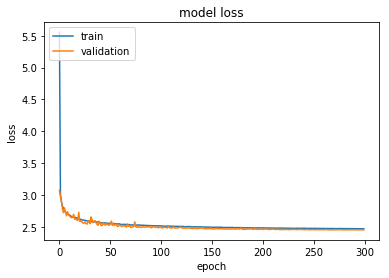

In [31]:
# Training history
# 2019-02-19

"""
[INFO    ] Done training. Time elapsed: 1:39:39.590503 sec
[INFO    ] Epoch 300/300 - loss: 2.46980567839 - regr_loss: 2.42485141397 - discr_loss: 0.002247713035 - val_loss: 2.45206501113 - val_regr_loss: 2.40037300845 - val_discr_loss: 0.00258460031038
"""

from IPython.display import Image
Image(format="png", data="iVBORw0KGgoAAAANSUhEUgAAAYUAAAEWCAYAAACJ0YulAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzt3Xl8XOV97/HP78yMdslaLLxijFmNjbGNAmYtFELYEiCBmCahhTZxoKSE26S9JLlZmldyS9uEEpbgQEIvJARKzJoAIZDgAA2bbYwxmN12vFteZO3SaOZ3/zhHsiw0Y3kZS/J836+XXzNz5pwzv6Ox5qvnec55xtwdERERgGCwCxARkaFDoSAiIj0UCiIi0kOhICIiPRQKIiLSQ6EgIiI9FAoiA2Rm/8/MvjfAdVeY2Zl7uh+RfU2hICIiPRQKIiLSQ6Eg+5Wo2+afzOx1M2s2szvNbJSZPWFmjWb2tJlV9Vr/E2b2hpk1mNl8M5vc67kZZrbIzJrM7L+Boj6vdb6ZLY62/ZOZTdvNmr9gZu+Z2RYze9TMxkbLzcz+08w2RrW/bmZTo+fONbM3o9rWmNlX9+gHJxJRKMj+6FPAmcARwPnAb4GvAwdE/+evIfxgPRy4F7gWqAUeB35tZgVmVgA8DPwcqAZ+Fe2XaNsZwJ3AF4Ea4CfAo2ZWuCuFmtlfAv8KfBoYA6wE7ouePgs4FTgcGBGtszl67mfAF929HJgK/GFv/gAlfykUZH90s7tvcPc1wHPAi+7+qru3Aw8BM6L1ZgOPuftT7p4EfgAUAycCs4AEcKO7J919HvBKr9eYA/zE3V9y95S73wV0RNvtis8Cd7r7InfvAL4GnGBmE4EkUA4cCZi7L3P3ddF2SeAoM6tw963uvmgv/ewkzykUZH+0odf9tn4el0X3x0Z/mQPg7mlgFTAuem6N7zhj5Mpe9w8CvhJ1HTWYWQNwYLTdruhbQ3PUGhjn7n8AbgFuBTaa2e1mVhGt+ingXGClmf3RzE7YxdcV6ZdCQfLZ2ujDHaI+/OiDfQ2wDhgXLes2odf9VcD33b2y178Sd793D2sojbqj1hCGxE3ufixwVNSN9E/R8lfc/YKoS+xh4P49+DmI9FAoSD67HzjPzM4wswTwlagL6E/AC0AXcI2ZJczsk8Bxvba9A7jSzI6PBoRLzew8MyvfxRruBa4ws+nReMT/BV5y9xVm9pFo/wmgBWgH0tGYx2fNbETU7dUIpPfyz0bylEJB8pa7vw18DrgZ2AR8HPi4u3e6eyfwSeByYEs0/vBgr20XAF+Iune2Au9F6+5qDU8D3wQeiFonhwCXRk9XROGzNepi2gz8R/TcZcAKM2sErozGJkT2mOlLdkREpJtaCiIi0kOhICIiPRQKIiLSQ6EgIiI94oNdwK4aOXKkT5w4cbDLEBEZVhYuXLjJ3Wt3tt6wC4WJEyeyYMGCwS5DRGRYMbOVA1hN3UciIrKdQkFERHooFEREpMewG1PoTzKZZPXq1bS3tw92KfuNoqIixo8fTyKRGOxSRGQf2i9CYfXq1ZSXlzNx4kR2nNRSdoe7s3nzZlavXs3BBx882OWIyD60X3Qftbe3U1NTo0DYS8yMmpoatbxE8tB+EQpEH2Sy9+jnKZKf9ptQ2Jn2ZIr129pJpjTtvIhIJnkVChub2kml9/5U4Q0NDfz4xz/e5e3OPfdcGhoa9no9IiK7K6ehYGYrzOx1M1tsZh+6DNnMTjOzbdHzi83sWzmrJbrNxbdHZAqFrq6urNs9/vjjVFZW5qAiEZHdsy/OPjrd3Tdlef45dz8/51XkMBWuu+463n//faZPn04ikaCoqIiqqireeust3nnnHS688EJWrVpFe3s7X/7yl5kzZw70mrKjubmZc845h5NPPpk//elPjBs3jkceeYTi4uK9X6yISBb7xSmpvf3Lr9/gzbWNH1qeSjvtyRTFBTGCXRxEPWpsBd/++JSMz19//fUsXbqUxYsXM3/+fM477zyWLl3aczrnnXfeSXV1NW1tbXzkIx/hU5/6FDU1NTvs49133+Xee+/ljjvu4NOf/jQPPPAAn/vc53apThGRPZXrMQUHnjazhWY2J8M6J5rZEjN7wsz6/eQ1szlmtsDMFtTX1+e24r3guOOO2+H8/ptuuoljjjmGWbNmsWrVKt59990PbXPwwQczffp0AI499lhWrFixT2sWEWEftBROdvc1ZnYA8JSZveXuz/Z6fhEwwd2bzexc4GHgsL47cffbgdsB6urqsnYAZfqLvrEtyYrNLRx6QBklBbk97NLS0p778+fP5+mnn+aFF16gpKSE0047rd/z/wsLC3vux2Ix2traclqjiEh/ctpScPc10e1G4CHguD7PN7p7c3T/cSBhZiNzWVMulJeX09TU1O9z27Zto6qqipKSEt566y1efPHFfV6fiMhA5exPZjMrBQJ3b4runwV8t886o4EN7u5mdlwUUptzVRPkZqC5pqaGk046ialTp1JcXMyoUaN6njv77LOZO3cukydP5ogjjmDWrFl7vwARkb0kl/0oo4CHoitj48Av3f23ZnYlYctgLnAxcJWZdQFtwKXunouzRukeW87JzoFf/vKX/S4vLCzkiSee6Pe57nGDkSNHsnTp0p7lX/3qV3NUpYhIdjkLBXf/ADimn+Vze92/BbglVzWIiMiuyZsrmkVEZOfyJhQ0vZuIyM7lTSh0y9WYgojI/iCPQiHHI80iIvuB/AmFnv4jpYKISCZ5EwpDaUyhrKwMgLVr13LxxRf3u85pp53GggUfmlh2BzfeeCOtra09jzUVt4jsqbwJhW5DqZ0wduxY5s2bt9vb9w0FTcUtInsq70IhF6677jpuvfXWnsff+c53+N73vscZZ5zBzJkzOfroo3nkkUc+tN2KFSuYOnUqAG1tbVx66aVMnjyZiy66aIe5j6666irq6uqYMmUK3/72tyGaZG/t2rWcfvrpnH766RBNxb1pUzhL+Q033MDUqVOZOnUqN954Y8/rTZ48mS984QtMmTKFs846S3MsicgO9rups3niOlj/+ocWF7kzqTNFUSKAYBezcPTRcM71GZ+ePXs21157LVdffTUA999/P08++STXXHMNFRUVbNq0iVmzZvGJT3wi43cf33bbbZSUlLBs2TKWLFnCzJkze577/ve/T3V1NalUijPOOIMlS5ZwzTXXcMMNN/DMM88wcuSO00UtXLiQ//qv/+Kll17C3Tn++OP5i7/4C6qqqjRFt4hkpZbCXjBjxgw2btzI2rVree2116iqqmL06NF8/etfZ9q0aZx55pmsWbOGDRs2ZNzHs88+2/PhPG3aNKZNm9bz3P3338/MmTOZMWMGb7zxBm+++WbWep5//nkuuugiSktLKSsr45Of/CTPPfccaIpuEdmJ/a+lkOEv+o7OLj7Y2MzEmlIqihN7/WUvueQS5s2bx/r165k9ezb33HMP9fX1LFy4kEQiwcSJE/udMntnli9fzg9+8ANeeeUVqqqquPzyy3drP900RbeIZKOWwl4ye/Zs7rvvPubNm8cll1zCtm3bOOCAA0gkEjzzzDOsXLky6/annnpqz6R6S5cuZcmSJQA0NjZSWlrKiBEj2LBhww6T62WasvuUU07h4YcfprW1lZaWFh566CFOOeWUvX7MIrL/2f9aChnk8CuaAZgyZQpNTU2MGzeOMWPG8NnPfpaPf/zjHH300dTV1XHkkUdm3f6qq67iiiuuYPLkyUyePJljjz0WgGOOOYYZM2Zw5JFHcuCBB3LSSSf1bDNnzhzOPvtsxo4dyzPPPNOzfObMmVx++eUcd1z49RWf//znmTFjhrqKRGSnLEczVedMXV2d9z1/f9myZUyePDnrdm2dXby7sZmDakoZkYPuo/3RQH6uIjI8mNlCd6/b2Xp51H2U67aCiMjwlz+hoEwQEdmp/SYUdtYNpkzYNcOtW1FE9o79IhSKiorYvHmzPsj2Endn8+bNFBUVDXYpIrKP7RdnH40fP57Vq1dTX1+fcZ1kKs2Gxg6SmwsoKYjt0/qGo6KiIsaPHz/YZYjIPrZfhEIikeDggw/Ous4H9c184hd/5EeXTueCyeP2WW0iIsPJftF9NBDdcw6l1cUkIpJR3oRC0P3Fa8oEEZGMchoKZrbCzF43s8Vm9qFvjLHQTWb2npktMbOZ/e9pL9RCd0shV68gIjL87YsxhdPdfVOG584BDov+HQ/cFt3uddbTUlAqiIhkMtjdRxcAd3voRaDSzMbk4oWCqP9ImSAiklmuQ8GBp81soZnN6ef5ccCqXo9XR8v2uu6L1zTQLCKSWa67j0529zVmdgDwlJm95e7P7upOokCZAzBhwoTdKiSI+o8UCSIimeW0peDua6LbjcBDwHF9VlkDHNjr8fhoWd/93O7ude5eV1tbu1u1dI8pqKUgIpJZzkLBzErNrLz7PnAWsLTPao8Cfx2dhTQL2Obu63JTT3irs49ERDLLZffRKOCh6KKxOPBLd/+tmV1J+Nf/XOBx4FzgPaAVuCJXxQSmCxVERHYmZ6Hg7h8Ax/SzfG6v+w5cnasaets+0LwvXk1EZHga7FNS95megWa1FEREMsq7UFBLQUQks7wJBXT2kYjITuVNKHRPiCciIpnlTSho6mwRkZ3Lm1DQ1NkiIjuXR6GggWYRkZ3Jm1Dopu4jEZHM8iYUeq5oFhGRjPImFHrmPlL/kYhIRnkTCpo6W0Rk5/IoFMJbjSmIiGSWN6FgOvtIRGSn8iYU6B5XUEtBRCSj/AoFtRRERLLKq1AIzDSmICKSRd6FgiJBRCSzvAoFTGcfiYhkk1ehEJguVBARySbPQkFjCiIi2eRVKOjsIxGR7PIqFAIzXaYgIpJFXoWCBppFRLLLeSiYWczMXjWz3/Tz3Glmts3MFkf/vpXLWjR9tohIdvF98BpfBpYBFRmef87dz98HdRCopSAiklVOWwpmNh44D/hpLl9noExnH4mIZJXr7qMbgX8G0lnWOdHMlpjZE2Y2pb8VzGyOmS0wswX19fW7XUxgmg9PRCSbnIWCmZ0PbHT3hVlWWwRMcPdpwM3Aw/2t5O63u3udu9fV1tbuSVU6JVVEJItcthROAj5hZiuA+4C/NLNf9F7B3RvdvTm6/ziQMLORuSoo/KIdpYKISCY5CwV3/5q7j3f3icClwB/c/XO91zGz0RZ9+42ZHRfVszlXNQVmpLN1ZImI5Ll9cfbRDszsSsLQmAtcDFxlZl1AG3Cpe+56/U1nH4mIZLVPQsHd5wPz2R4G3ctvAW7ZFzWgqbNFRHYqv65oRi0FEZFs8ioUgkCnpIqIZJNfoWBGDocsRESGvbwKBU2dLSKSXV6FggaaRUSyy6tQ0CmpIiLZ5VkoaExBRCSbvAoFTYgnIpJdXoWCoamzRUSyya9QUEtBRCSrvAqFwDR1tohINnkVCmFLQakgIpJJXoWCrlMQEckur0JB1ymIiGSXZ6FgGmgWEckir0IhUEtBRCSrvAoFQ6ekiohkk1ehEA40KxVERDLJq1Awg3R6sKsQERm68iwU1FIQEclmQKFgZl82swoL/czMFpnZWbkvb+8KB5oHuwoRkaFroC2Fv3X3RuAsoAq4DLg+x7XtdYamzhYRyWagoWDR7bnAz939jV7Lho0g0NlHIiLZDDQUFprZ76JQeNLMyoEBDdmaWczMXjWz3/TznJnZTWb2npktMbOZu3wEu0BTZ4uIZBcf4Hp/B0wHPnD3VjOrBq4Y4LZfBpYBFf08dw5wWPTveOC26DYnTGMKIiJZDbSlcALwtrs3mNnngP8DbNvZRmY2HjgP+GmGVS4A7vbQi0ClmY3ZtUMYOE2IJyKS3UBD4Tag1cyOAb4CvA/cPYDtbgT+OUtX0zhgVa/Hq6NlOzCzOWa2wMwW1NfXD7DkD9PU2SIi2Q00FLo8/DS9ALjF3W8FyrNtYGbnAxvdfeGeFunut7t7nbvX1dbW7vZ+Ak2IJyKS1UDHFJrM7GvRqainmFkAJHayzUnAJ8zsXKAIqDCzX7j753qtswY4sNfj8dGynNCEeCIi2Q20pTAb6IiuV1gffXj/R7YN3P1r7j7e3ScClwJ/6BMIAI8Cfx2dhTQL2Obu63b/cHZGX8cpIpLNgEIhCoJ7gBFRt1C7uw9kTOFDzOxKM7syevg48AHwHnAH8Pe7s8+BCjSmICKS1YC6j8zs01HLYH500drNZvZP7j5vINu7+/xoW9x9bq/lDly9B/XvknCgeV+9mojI8DPQMYVvAB9x942EIVELPA0MKBSGCk2dLSKS3UDHFILuQIhsHo4zrAamMQURkWwG2lL4rZk9CdwbPZ4djQcMLzr7SEQkqwGFgrv/k5l9KjrNFOB2d38ot6XtfYEZ6j0SEclsoC0F3P0B4IHclpNbhloKIiLZZA0FM2ui/7+tLTp5qL9J7oasQA0FEZGssoaCu2edymK4CQeaFQsiIpkMuzOI9ohBekDfAiEikp/yKhQCG3ZfFicisk/lVShooFlEJLu8CgWNKYiIZJdfoRBo7iMRkWzyKhQ0dbaISHZ5FQqBkeGyCxERIf9CQS0FEZFs8ioUTBPiiYhklVehEJhpoFlEJIu8CgV0nYKISFZ5FQqaOltEJLs8CwW1FEREssmrUAgHmge7ChGRoSuvQiEww9V/JCKSUV6FAmopiIhklbNQMLMiM3vZzF4zs2Vmdn0/65xmZtvMbHH071u5qgcNNIuI7NSAv6N5N3QAf+nuzWaWAJ43s1Pc/bk+6z3n7ufnsI4eGmgWEckuZ6Hg7g40Rw8TQAzYmqvXGwhDU2eLiGST0zEFM4uZ2WJgIzDf3Zf2s9qJZrbEzJ4wsykZ9jPHzBaY2YL6+vrdridQ75GISFY5DQV3T7n7dGA8cIqZnd5nlUXABHefBtwMPJxhP7e7e52719XW1u5+QdE0F67WgohIv/bJ2Ufu3gA8BtT1Wd7o7s3R/ceBhJmNzFUdgXW/bq5eQURkeMvl2Ue1ZlYZ3S8GPgos7rPOaDOz6P5xUT2bc1VTEL6UupBERDLI5dlHY4C7zCyIPux/4e5PmdmVhC2DucDFwFVm1gW0AZd6Dvt2ooYCaXdiPY9ERKRbLs8+WgLM6Gf53F73bwFuyVUNfQVR/5G6j0RE+pdfVzRHdFqqiEj/8ioUesYUlAkiIv3Ks1AIbzUpnohI//IqFKKGgibFExHJIK9CYXv3kVJBRKQ/eRUK0SURaimIiGSQX6EQ3aqlICLSv7wKBU1zISKSXV6FwvbuI6WCiEh/8ioUtp+SKiIi/cmrUFBLQUQkuzwLhfBWmSAi0r+8CgVNcyEikl1ehULvqbNFROTD8ioUAo0piIhklVehoDEFEZHs8iwUNKYgIpJNXoWCps4WEckur0JBU2eLiGSXV6GggWYRkezyJxQaVnHQynkU0aExBRGRDPInFNYuYvqr3+IQW6ups0VEMsifUBh5BACH2RoNM4uIZJCzUDCzIjN72cxeM7NlZnZ9P+uYmd1kZu+Z2RIzm5mreqieRNriHBas1piCiEgGuWwpdAB/6e7HANOA083slD7rnAMcFv2bA9yWs2riBbSWHcShtpZ0OmevIiIyrOUsFDzUHD1MADFga5/VLgDujtZ9Eag0szG5qqltxCEcamto6ezK1UuIiAxrOR1TMLOYmS0GNgLz3X1pn1XGAat6PV4dLeu7nzlmtsDMFtTX1+92PbHRkznINrCmvmG39yEisj/LaSi4e8rdpwPjgVPM7PTd3M/t7l7n7nW1tbW7XU/5+KnELU3zmjd3ex8iIvuzfXL2kbs3AI8BdX2eWgMc2Ovx+GhZTiQOPBaAgvWLcvUSIiLDWi7PPqo1s8rofjHwUWBxn9UeBf46OgtpFrDN3dflqiaqJ7EtGEFtw2s5ewkRkeEsnsN9jwHuMrMgCp9fuPtTZnYlYethLvA4cC7wHtAKXJHDesCMVaVHc0jTGzl9GRGR4SpnoeDuS4AZ/Syf2+u+A1fnqob+bBs5g6lNz9O2dQPFVaP25UuLiAx5+XNFc7exYU5ten/hYFciIjLk5F0ojD34KAA2rHxrsEsRERly8i4UDpp4GEliNK9/b7BLEREZcvIuFIJ4nM3x0cQaVgx2KSIiQ07ehQJAW9kEKjvW0NSeHOxSRESGlLwMhaJRh3KQbeTRxTm7Tk5EZFjKy1AYfdARVFgrj/7uabp++jFoWDWArURE9n95GQpWPQmAizp/TXz1i/D2E4NdkojIkJCXocDY8Lt8Lor/KXz85xcGtx4RkSEiP0OhYgxUH0IhnQB0rfgT6NvYRETyNBQAJp4EwCYfQbxlPe8u/AP8+ARY//rAtn/7CWhcm9saRUT2sfwNhYNOBiCYNQeAtt9cBxvfhEV373zbZBvc9xl4ae7O1xURGUbyNxSOugDO/jeqP/rPdJWOZhrvANC46AGSXb2+rtMdXrsPWjZvX7ZtNXhaZy2JyH4nf0MhUQSzroR4AfEjzgKgNVZBRddmbrj1ZtZtawvXW/UyPPRFWHDn9m0b/hzeNuo6BxHZv+RvKPR26EcBKPnoN2gsP5QvbflX/vGHd3Dn88tJvXZvuM7aV7evvy1qIWxTKIjI/kWhAHDEOXDOv8PMv6ZizmMUVI7hp/F/Y/Hjd9C88FcAtKxcwBtrt5FK+/aWQtM6SKcG9hrzr4dn/yOHByEisucUCgCxBBz/RSgogfLRJK74NSVVo7mp4FYSluZxO5nS9g1cftOvmf7d37H0zaXhdp6CpvUDe435/wp/+B60bsnpoYiI7AmFQn8qJ2BffA7Ov5GSa1/hnL/5GgCvFF3Nf1Y9SFv9clJuADz87EssWd2QfX/Jtu33F9+T09JFRPZELr+jeXgrKIG68CujragSKsZDLMGZW++DADYUTWJU+wc89cKrPPY/hRw+qowZB1Zx6AFlHDqqjBMm1VCUiIX72rJ8+34X/xJO/AdIdQEetlJERIYIhcJAFJbBP74B6TQ89U144RZGzTgXXriFWwtu4oIjRnJ/xwk8vnQdTe3h6ayF8YCpY0qZs+1HHGZrmAQ0HPZJKt99EJ76Nr7obrx6EsHnnwYz+GA+bH4PPvL5gdW0ZXl4quxf/G8I1OATkb3DfJhN71BXV+cLFiwY3CLWL4XqSXDnWbD5A0i2wIzLSJ1/E8mn/oUPgoOY1zGLI96dy+zGu3o2+1jH9TxZeB0Af/YDmGAb+WHNd1hcciJf3/AVjkguo/Hvl1JZO4au5s10NaylaPzR/dfwwOfh9V/BF5+FMcfs3eNLdcEdp8OJ18C0S/buvkVkUJjZQnev29l6ainsjtFTw9srnw9bD7//F/ifG4nVv01s9cscZTG+deGP4bX/hpGHw6bwwrgvXvJxVv72Z1R0beLB6Xdx2dLPc1HDXTyfmsohnW8R0MUPf/TvvFRzIVc23MB5/A+XlP2EhthIjp9UzdjKYkoSMUqSm7nkjYcxoOPFn1KYasE/cTNWULp3jm/T27B+Cbz9mEJBJM8oFPZUEMCZ3wnHB166HY44D7YuDy94sxhc+ku4JQznT84cD5MehHSKa6sPhkO+T82vLuehcb+EhiRuca4c8RL11bM5p3khhakkV8V/w3+Vf5FJr/47p/oCLuv8Gn8T/x0WT9LoJVS8Fk7L8fVXq1gbG0dD0Tjai8eQiBubmzv5zHETOHx0OQXxAByWb2qhvCjOUdUBB/7harpO+wbp0dOoKS3ALBw877kmo/e1GSKSF3LWfWRmBwJ3A6PCT0xud/cf9VnnNOARoHsk9kF3/262/Q6J7qNMOlshXgitm+HeS2HCCfCx74dXRSeKYXSfriB3uPsCWP7H8PEZ34LffxemXgxL54VdVFs+gJKR0LoJtxipqkkEDSt5u/YsSmIpDlobfhdEmhgBKboszg/G3EBzOsFfbZ3LT5pO5tH0iZTSzqWxP/BA6lTaKeDs4BVuLPgxv0kdz5eSX+aYAysB6Eql+buGm/lk+kkAvjT+ARLlI2lsS9LameLA6mLGVZZQmAhobEsyrqqYg2tK2dqaJBbAxJGljCovormji+KC2I5hIyKDZqDdR7kMhTHAGHdfZGblwELgQnd/s9c6pwFfdffzB7rfIR0Ku6NtK/zqivAspL/6b/j5BbD8WUiUwv9aGp6ttH4JTDodykfBY18Jt7nqBXjvafjNtTD9M+FEfif/r7DLqmgEdDaH03B4ms1TLiex5V0q1v0PqcqJBNtW0VlQRWHHJtIWZ9mo87ix8TS2jZjMiV2vcNWm7wNQ6O18s/y7vNVRS2fxSBJFZbxf38zW1iQz7F0arZT302MBKKadBCkaKWW81ZN2Yy0jiQVGpbUSBAHtQSlBYMQD67mNGZQUxplQXUpVSYJkKs0BFUVsaekkaFrLrLbnWDDqYoqLiqguLaCrK01Z+xrKRh+CO6QdasoKSKWd+qYOJo4sJWbGqq2tHDWmggOrSygrjNOWTLF8UwtFiXBQfnxVuFwkXwx6KPRT0CPALe7+VK9lCoW+ku2w4nkorYGxMz78vHt4FXUsHt42roWKsbBmEYyvgzcegnlXQOkB8Ff3hddFLPgZWADTZsNr9/a0PDj0o+FZT+lkuOyoC8J1AY69HBb+P6g9Eja9C1UTobAcqiaSHv8R7KlvQRCncdJ5tAWl1K54lKCzicaySZQ3r6CjoJLfH/0fHLL8Hg7f8gxdVshLo2aTdqPTErw64kzOXvtjxrS/xw2jrueDBueo1peopYHVnSW8XHwK/5b+IXVdr/Lj2Ge4ufMC2pJd/EPsIb6SmMfVndfwWHpWz4+lmHYuif2R82Iv8cPkJWyhnPd9LE7AWDaxjmpODpayLH0QmxiBGZQkYoytLGZDYzvtyTSJmJGIBxTEAhKxgIJ4wKbmDipLEkysKSURC4gHRjxmxIOAtmSKokSM2rJCtrUlKYgbh9SWEZixuaWD6tJC2pMp1m9r54DyQmIxo6E1yaiKIsZVFlFdWkgq7aTdiQdha6ozlaamtJCNTe09rzG+qphxVcU0tCRJuWOEJ6wFUQssFhi15YUkYtvPQmtPpiiIBQSBWmkSGlKhYGYTgWeBqe7e2Gv5acCDwGpgTRQQb/Sz/RxgDsCECROOXblyZc5rHtbaGsLWglk4EL7oq7cyAAAMmUlEQVT+NagYB2UHQMumcIbXX18LZ34biiqhbQvcc0k4p9OUi+DQM+Gws+Dtx+H5/4TR0+DPL0JJdTgzbLIlDKzKg2DNwrDlMnYGTJgVfh9F2QFhiyXVAYkSqPtb2LgM3v99GE6eDuu0WPg8Hi5Ltm4/hiARhlXFOGhci1dPgoaV0baGJ0roqj4M62oj3dFCom0TQVcrqXgpsa4WANaPPo1mK+fQdb9ma8nBVLUupytWwvJDL2NTm7HVS3gjOZYJiQZOaHiMP5dO453y4xjZ8i7tnqCiYx1T2hexzkZR0/FnGmwEc4s+zwaqKUk1URKkGNGxhtaOLj6S+ICq9Baua7uMJHECg1NtMZPtz8xPnER5x0Ze9cOojbWyPlVGei9cN1rLVr6Z+AU/7/ooi2wyRfGAeCwgFhhbWjpJxIyiRIxEtCweGBVFCYLAmBjfytZ0MQ2pQprau+hKpyktjINDEBhdqTTJlFNZkqCiKEEq+pwojAe0daYoiAcUxsPgNMLgqSpNUBiPsaWlk86uNFWlCZrauyhKxMLpYYDyojjlRXFiQUBgELOw1Wjd96PHMYPCRIyG1iQNrZ0cWF1Cc0cX8SA8pg2N7VSWFJBOO7HAKCuMEwuMkeWFbG3ppLUzRSJmFMTDgN/a2okRhidRN2lhIqAoHl5L1NEV/p8sKYhRmIj1BK8R1kb0uPvjsrggxsiyQprak7hDQ2tyh/VGFCeI9Qnk7p9T93qBWfgzCAwzIxaEj4Po59D9eG91vw6ZUDCzMuCPwPfd/cE+z1UAaXdvNrNzgR+5+2HZ9rfftxQGSzoNTWvDD+H+/hOmuiCIQUdj2DqpOTT7hXdvPxG2MI65NAwJgI6m8Ldqw9KwZXPomeFUIS/fEQZD3d9C9SFQ/za8+TB0tcPpX4cXb4PVC8LXbKmHWX8fziOVToahkigJQ/DoS6D64HA6kYKy8PsuzODws+Gtx8LA83S4775Ka8N992axMOw2vhm2ktq2Qqoz648xNWIiHi8ilu7Ati7f4Tm3APM0bjG6SmppKxpFV1EN8WQThc2raak8gsK29XSlwUpqcAjHidpbKGhZT+OIwyltW0ci2USQTpIOEhR31NMVFPF+5YmsLJlKlwcUJ7dQE7SQ6NxGSUc95inKk5tIYywrPIZOK+DUpsfZGqvhmREXEksUMyK9lVRXkimtL9FhRbxUcTajUusoaN9MLNVGkbexPjaGZcERJBJx4qk2Sru2MqJrMymMAk/yTGo6FaktjCgEtzjvJGtpLhoNyXZKg04K6KSjo5POzk4CUqQxVvkBOEYlzRwdLGebl9JAGeOtnpU+iiYvIRGDqvRWYqQZYS00ezH1VLLRK9nsFYy1zVRbI9u8jFU+kgQpApxO4hxkG9hCBeB0eoJa20Y7CbZ6OQm6SBEjIE0bhRSSpIliDrW1lFsrL6eP3Gl4l9DOaNvCSh9FGW1UWxMrfBSecTunkCQltLOVcgroopM4kPmDv7tVGDNjzqmT+OrHjshaU+b9DIFQMLME8BvgSXe/YQDrrwDq3H1TpnUUCjJg7dsgXgzxAmjeGH7wm8HWlVBcGZ4YsPHNsAU06mhY9WI4JcmoKdDVAcVV0XotYctlywfhGVlN68IgKigNw6KzGdJdECsIu+/ihRArhNojoOYQWPUKjJkWtpZGjA9raVoXhmvrJogXQfloqH8nDDUsPFnBDIJ4uN+SatjwZnjyQWlNGK7rl8AJXwpbdGsWhS0pCFtjxVVhK7B8TBjmZQeENb7zZHg7+eNh0PZsE119X3NI+HNr3hAec+nIsL6iirC+rrYdf8aJ0jDYsQ8/N8w5hlsMtwAsiD7ow+47B9ydWLqTgPQO23XFSkhHP08jDe64BSTjZRR2biWe7gCgM1ZKQaqFlCVoL6gk0dUSbmFxUhanINVCR6yMmHeSthgdsVK2TL6MQy+4breOZ9BDwcI2z13AFne/NsM6o4EN7u5mdhwwDzjIsxSlUBDJoGl9+EFeXJX5KvdkexQ00ZhUZzN0dYYf+hYLA6SrA1o2huNMBSU7brt1RdjaKiwLg7GkJtxP+zaoXxaOPcWLwnDd8n5YU7woatEVhfUF8bC+dCoMaLNwnbEzwi7Elk0wYlz4Wl0dYQCW1YbhWFgR1ty0Pgyu5o3hmFr56DBIG/4crhfEw5Zm+Zgo4OKQSm4P8a72KNDS4TEn28IzBDuawmMqqggvUvV0GHqe3t531LslnSgNg37bqrC2wvLwDw33qP8pCAPTU2G3blktFFeHfzhsfh/KRoXdsS2bw20tCFuj6WS4747G8GfjqbC2w8+Goy/erf8eQyEUTgaeA16Hnij9OjCBMGXnmtmXgKuALqAN+Ed3/1O2/SoURER23aBf0ezuz2ftKAvXuQW4JVc1iIjIrtFMaiIi0kOhICIiPRQKIiLSQ6EgIiI9FAoiItJDoSAiIj0UCiIi0mPYfR2nmdUDuzsj3kgg4xQaw4yOZWjSsQxNOpZwtojana007EJhT5jZgoFc0Tcc6FiGJh3L0KRjGTh1H4mISA+FgoiI9Mi3ULh9sAvYi3QsQ5OOZWjSsQxQXo0piIhIdvnWUhARkSwUCiIi0iNvQsHMzjazt83sPTPbve+zG0RmtsLMXjezxWa2IFpWbWZPmdm70W3VYNfZHzO708w2mtnSXssy1m5mX4vep7fN7GODVng/MhzLd8xsTfTeLI6+b7z7uSF5LGZ2oJk9Y2ZvmtkbZvZlhun7kuVYhuP7UmRmL5vZa2a2zMyuZ1+/L+6+3/8DYsD7wCSgAHgNOGqw69rFY1gBjOyz7N+B66L71wH/Nth1Zqj9VGAmsHRntQNHRe9PIXBw9L7FBvsYdnIs3wG+2s+6Q/ZYgDHAzOh+OfBOVO+we1+yHMtwfF8MKIvuJ4CXgFP25fuSLy2F44D33P0Dd+8E7gMuGOyi9oILou/BJrq9cJDr6Ze7Pwts6bM4U+0XAPe5e4e7Lwfei96/ISHDsWQyZI/F3de5+6LofhOwDBg3HN+XLMeSyVA+Fnf35uhhIvqDduu+fF/yJRTGAat6PV69k/80Q5EDT5vZQjObEy0b5e7rovvrgVGDWN+uylT7cH2v/sHMlkTdS91N+2FxLGY2EZgR/VU6rN+XPsfCcHxfzCxmZouBjcB8d1+6L9+XfAmF/cHJ7j4dOAe42sxO7f2kh23JYXl+8XCuPXJb1DU5HVgH/HCwCxooMysDHgCudffG3s8Nt/eln2MZlu+Lu6ei3/XxwClmdnqf53P6vuRLKKwBDuz1eHy0bNhw9zXR7UbgoaiJuMHMxhD+QoyJ/rIYLjLVPuzeK3ffEP0ip4E7ejXfh/SxmFki+hC9x90fjBYPy/elv2MZru9LN3dvAB4D6vbl+5IvofAKcJiZHWxmBcClwKODXdRAmVmpmZV33wfOApZGx/A30Wp/AzwyuJXukky1PwpcamaFZnYwcBjw8iDWuVPdv6yRi6L3hqF8LGZmwM+AZe5+Q6+nht37kulYhun7UmtmldH9YuCjwOJ9+r4M9mj7PhzVPzc6K+F94BuDXc8u1j4pOsPgNeCN7vqBGuD3wLvA00D1YNeaof57o+Z7Murz/LtstQPfiN6nt4FzBrv+ARzLz4HXgSXRL+mYoX4swMlRF8SS6ENncfQ7MuzelyzHMhzfl2nAq9Hv+uvA//ad/K7v7WPRNBciItIjX7qPRERkABQKIiLSQ6EgIiI9FAoiItJDoSAiIj0UCiL7kJmdZma/Gew6RDJRKIiISA+Fgkg/zOxz0bz2i83sJ9EkZc1m9p/RnP2/N7PaaN3pZvZiNPHaQ90Tr5nZoWb2dDQ3/iIzOyTafZmZzTOzt8zsnuiKXJEhQaEg0oeZTQZmAydFE5OlgM8CpcACd58C/BH4drTJ3dGVp9Oiq1C7l98D3OruxwAnRldCE83ieW00F/4k4KRBOlSRD4kPdgEiQ9AZwLHAK9Ef8cXRBGRp4L+jdX4BPGhmI4BKd/9jtPwu4FfRXFXj3P0hwulk2gkDB+Bld18dPV4MTASeH5xDFdmRQkHkwwy4y92/tsNCs2/2WW9354jp6HU/pd9DGUrUfSTyYb8HLjazA9j+/bgHRb8vF0frfAZ43t23AVvN7JRo+WXAH6NvAFttZhdG+yg0s5JBOyKRAdJfKCJ9uPubZvZ/gN+ZWRDNiHo10AIcFz23MRp3IJrKeG70of8BcEW0/DLgJ2b23WgflwziYYkMiGZJFRkgM2t297LBrkMkl9R9JCIiPdRSEBGRHmopiIhID4WCiIj0UCiIiEgPhYKIiPRQKIiISI//D7GnJJ9u5KEIAAAAAElFTkSuQmCC")

In [32]:
if False:
  import nn_encode
  reload(nn_encode)
  import nn_data
  reload(nn_data)
  from nn_encode import Encoder
  from nn_data import muon_data_split

  adjust_scale = 0
  reg_pt_scale = 1.0
  correct_for_eta = True
  
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.5, correct_for_eta=correct_for_eta)

  if not isinstance(y_train, list):
    y_train = [y_train]

In [33]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  #print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid]/reg_pt_scale

    xmin, xmax = -2, 2
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -3, 3
    if adjust_scale == 0:
      _range = None
    else:
      _range = [[xmin, xmax], [ymin, ymax]]
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=_range, cmap=plt.cm.viridis)
    if x_i.size > 0:
      print i, x_i.size, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [34]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 7) + 3)
  
  y_train_stdev = np.std(y_train[0]/reg_pt_scale)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < discr_pt_cut/reg_pt_scale)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = (y_train[0][valid]/reg_pt_scale).copy()
    assert(np.isfinite(x_i).all())
    
    nentries_test = 120000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= y_train_stdev
    #y_i /= (1.0/np.sqrt(12))  # stdev: (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay in (0,1,2,3,4) or lay in (9,10,11,):  # ME1/1, ME1/2, ME2, ME3, ME4, GE1/1, GE2/1, ME0
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        elif lay in (5,6):  # RE1, RE2
          coef = 1.0/np.std(x_i)
        else:  # RE3, RE4
          coef = -1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      coefs[i] = coef

  print np.array2string(coefs, separator=', ', precision=6, floatmode='fixed')

In [35]:
if False:
  with np.load(infile_muon) as loaded:
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']

  from nn_encode import Encoder
  encoder = Encoder(the_variables, the_parameters, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale)
  x, x_mask, y_pt, y_eta = encoder.get_x(), encoder.get_x_mask(), encoder.y_pt.copy(), encoder.y_eta.copy()

  y_pt_cut = (np.abs(1.0/y_pt) > discr_pt_cut/reg_pt_scale)  # select high pT part
  x, x_mask, y_pt, y_eta = x[y_pt_cut], x_mask[y_pt_cut], y_pt[y_pt_cut], y_eta[y_pt_cut]
  
  nentries_test = 120000 * 2
  x, x_mask, y_pt, y_eta = x[:nentries_test], x_mask[:nentries_test], y_pt[:nentries_test], y_eta[:nentries_test]

In [36]:
if False:
  fig, axs = plt.subplots(12/4, 4, figsize=(4*4,4*12/4), tight_layout=True)
  
  for i in xrange(12):
    mask = x_mask[...,i].copy()
    
    valid = ~mask  # valid hits
    
    denom_hist, edges = np.histogram(np.abs(y_eta), bins=70, range=(1.1,2.5))
    num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=70, range=(1.1,2.5))
    eff_hist = np.true_divide(num_hist, denom_hist)
    
    xdata = (edges[1:] + edges[:-1])/2
    ydata = eff_hist
    
    xmin, xmax = 1.2, 2.5
    ymin, ymax = 0, 1.05
    
    axs[i/4,i%4].errorbar(xdata, ydata, color='b', marker=',', capsize=0, lw=1)
    for x in [1.24, 1.55, 1.7, 1.8, 1.98, 2.15, 2.4]:  # vertical lines
      axs[i/4,i%4].plot([x,x], [ymin,ymax], '--', color='grey')
    for y in [0.95]:  # horizontal lines
      axs[i/4,i%4].plot([xmin,xmax], [y,y], '--', color='grey')
    axs[i/4,i%4].set_xlim(xmin,xmax)
    axs[i/4,i%4].set_ylim(ymin,ymax)
  
  plt.show()

In [37]:
if False:
  # Check loss functions
  from keras.losses import mean_squared_error, mean_absolute_error
  
  def huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)
  
  def asymmetric_huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    x2 = K.abs(y_true) - K.abs(y_pred)  # x2 >= 0: underprediction of 1/pT -> overprediction of pT
    xx = tf.where(tf.logical_or(x < delta, x2 >= 0), squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)

  nentries_test = x_test.shape[0]//100

  # Prepare y_test_true, y_test_meas
  y_test_true = y_test
  if isinstance(y_test_true, list):
    y_test_true = y_test_true[0]
  y_test_true = y_test_true[:nentries_test].copy()
  y_test_true = y_test_true.reshape(-1)
  #y_test_true /= reg_pt_scale

  y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
  if isinstance(y_test_meas, list):
    y_test_meas = y_test_meas[0]
  y_test_meas = y_test_meas.reshape(-1)
  #y_test_meas /= reg_pt_scale
  
  sess = K.get_session()
  diff = y_test_true - y_test_meas
  mask = np.abs(y_test_true) - np.abs(y_test_meas) > 0.
  
  loss1 = mean_squared_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss2 = mean_absolute_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss3 = huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss4 = asymmetric_huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  
  plt.figure()
  #plt.scatter(diff, loss1, c='r', s=2, edgecolors='none')
  #plt.scatter(diff, loss2, c='g', s=2, edgecolors='none')
  #plt.scatter(diff, loss3, c='b', s=2, edgecolors='none')
  plt.scatter(diff[mask], loss4[mask], c='magenta', s=2, edgecolors='none')
  plt.scatter(diff[~mask], loss4[~mask], c='cyan', s=2, edgecolors='none')
  #plt.legend(['mse', 'mae', 'huber', 'asym huber #1', 'asym huber #2'])
  plt.xlim(-5,5)
  plt.ylim(-1,11)
  plt.show()
  
  print y_test_true.shape, y_test_true, y_test_meas, diff, np.percentile(diff, [25,50,75], overwrite_input=True)

In [38]:
if False:
  from keras.models import Model
  layer_name = 'batch_normalization_1'
  intermediate_layer_model = Model(inputs=loaded_model.input, outputs=loaded_model.get_layer(layer_name).output)
  
  y_test_bn1_sel = (y_test_true[1][:nentries_test] != mask_value)  # skip low pT muons
  y_test_bn1 = intermediate_layer_model.predict(x_test[:nentries_test][y_test_bn1_sel], batch_size=4096)
  pu_y_test_bn1 = intermediate_layer_model.predict(pu_x_test, batch_size=4096)
  
  print y_test_bn1.shape, pu_y_test_bn1.shape
  assert(y_test_bn1.shape[1] == pu_y_test_bn1.shape[1])
  
  x_mask_test_bn1_tmp = x_mask_test[:nentries_test][y_test_bn1_sel]
  assert(x_mask_test.shape[1] == 16)
  x_mask_test_bn1 = np.ones_like(y_test_bn1, dtype=np.bool)
  x_mask_test_bn1[:, 0:12] = np.hstack((x_mask_test_bn1_tmp[:,0:12],))
  x_mask_test_bn1[:, 12:24] = np.hstack((x_mask_test_bn1_tmp[:,0:12],))
  x_mask_test_bn1[:, 24:30] = np.hstack((x_mask_test_bn1_tmp[:,0:5], x_mask_test_bn1_tmp[:,11:12]))
  x_mask_test_bn1[:, 30:36] = np.hstack((x_mask_test_bn1_tmp[:,0:5], x_mask_test_bn1_tmp[:,11:12]))
  x_mask_test_bn1[:, 36:39] = 0
  
  pu_x_mask_test_bn1_tmp = pu_x_mask_test
  assert(pu_x_mask_test.shape[1] == 16)
  pu_x_mask_test_bn1 = np.ones_like(pu_y_test_bn1, dtype=np.bool)
  pu_x_mask_test_bn1[:, 0:12] = np.hstack((pu_x_mask_test_bn1_tmp[:,0:12],))
  pu_x_mask_test_bn1[:, 12:24] = np.hstack((pu_x_mask_test_bn1_tmp[:,0:12],))
  pu_x_mask_test_bn1[:, 24:30] = np.hstack((pu_x_mask_test_bn1_tmp[:,0:5], pu_x_mask_test_bn1_tmp[:,11:12]))
  pu_x_mask_test_bn1[:, 30:36] = np.hstack((pu_x_mask_test_bn1_tmp[:,0:5], pu_x_mask_test_bn1_tmp[:,11:12]))
  pu_x_mask_test_bn1[:, 36:39] = 0
  
  print x_mask_test_bn1.shape, pu_x_mask_test_bn1.shape
  assert(x_mask_test_bn1.shape[1] == pu_x_mask_test_bn1.shape[1])

In [39]:
if False:
  fig, axs = plt.subplots(40/4, 4, figsize=(4*4,4*40/4), tight_layout=True)
  
  _kwargs = dict(histtype='stepfilled', alpha=0.4, density=True, bins=40)
  
  for i in xrange(y_test_bn1.shape[1]):
    # Background in red
    mask = pu_x_mask_test_bn1[:,i]
    valid = ~mask
    hist = axs[(i/4, i%4)].hist(pu_y_test_bn1[:,i][valid], color='red', **_kwargs)
    
    # Signal in blue
    mask = x_mask_test_bn1[:,i]
    valid = ~mask
    hist = axs[(i/4, i%4)].hist(y_test_bn1[:,i][valid], color='blue', **_kwargs)

In [40]:
if False:
  # Tensorflow Interface for CMSSW
  # https://github.com/riga/CMSSW-DNN#keras
  
  import tensorflow as tf
  #sess = tf.Session()

  from keras import backend as K
  #K.set_session(sess)
  sess = K.get_session()

  # save at as a constant graph
  ## names found with: [node.op.name for node in loaded_model.outputs]
  ## to get all nodes: [n.name for n in tf.get_default_graph().as_graph_def().node]
  #outputs = [u'regr/BiasAdd', u'discr/Sigmoid']
  outputs = [u'dense_7_1/BiasAdd']
  constant_graph = tf.graph_util.convert_variables_to_constants(
      sess, sess.graph.as_graph_def(), outputs)
  tf.train.write_graph(constant_graph, "/tmp/jiafu", "constantgraph.pb", as_text=False)

  # save it as a SavedModel
  builder = tf.saved_model.builder.SavedModelBuilder("/tmp/jiafu/simplegraph")
  builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
  builder.save()